In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler_poise
import kl_divergence_calculator
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
import random
from scipy.stats import multivariate_normal
random.seed(30)

importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


In [2]:
""" Standard bivariate normal r.v. generator as a function """
def twoDimCircGauss_gen(no_samples):
    """
    no_samples: number of samples
    """
    # Generate two uniformly distributed vectors stored in the array U with shape (no_samples,2)
    U = np.random.uniform(0, 1, (no_samples,2))
    
    # Allocate an empty array 
    Z = np.empty(shape=(no_samples,2))
    
    # Use Box-Muller method
    Theta, R = 2*np.pi*U[:,0], np.sqrt( -2*np.log(U[:,1]) )
    Z[:,0] = np.multiply(R, np.cos(Theta))
    Z[:,1] = np.multiply(R, np.sin(Theta))
    
    return Z
def twoDimColorGauss_gen(mu, Sigma, no_samples):
    """
    mu: mean vector of shape (2,1)
    Sigma: covariance matrix of shape (2,2)
    no_samples: number of samples
    """
    # Generate no_samples from standard bivariate normal distribution and store them in the array Z with shape (no_samples,2)
    Z = twoDimCircGauss_gen(no_samples)
    
    # Eigendecomposition of Sigma: the columns of U are the orthonormal eigenvectors, and Lambda holds the corresponsing eigenvalues
    Lambda, U = np.linalg.eig(Sigma)
    # Compute the transformation matrix A = U*diag(Lambda)^(1/2)U^T
    A = np.matmul( U, np.matmul(np.diag(np.sqrt(Lambda)),np.transpose(U)) )
    
    return np.matmul(A,np.expand_dims(Z,2)).squeeze(-1) + np.repeat(mu.T, no_samples, axis=0)

**Synthetic dataset**
The mean and variance of the two datasets is given by
<span class="math display">
    \begin{aligned}
    \mu_1&=1\\
    \sigma_1 &=1\\
    \mu_2&=2\\
    \sigma_2 &=2\\
    \rho     &=0.5
    \end{aligned}
</span>


In [3]:
## Creating synthetic datasets
nb_samples= 10**4
mu, Sigma = np.array([[1],[2]]), np.array([[1,0.5],[0.5,2]])
X = twoDimColorGauss_gen(mu, Sigma, nb_samples)
np.shape(X)

(10000, 2)

In [4]:
## Creating synthetic datasets

inp_data1=torch.from_numpy(X[:,0])
inp_data1=inp_data1.unsqueeze(0)+torch.randn_like(inp_data1)##Adding gaussian noise to data
inp_data1=torch.transpose(inp_data1,0,1)

inp_data2=torch.from_numpy(X[:,1])
inp_data2=inp_data2.unsqueeze(0)+torch.randn_like(inp_data2)  ##Adding gaussian noise to data
inp_data2=torch.transpose(inp_data2,0,1)

inp_data1= inp_data1.type(torch.FloatTensor)
inp_data2= inp_data2.type(torch.FloatTensor)

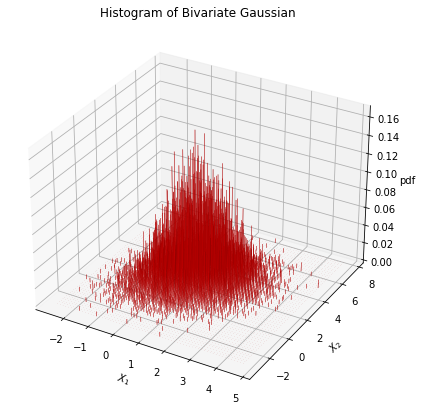

In [5]:
# plot the histogram
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=65, normed=True)
mu1, mu2 = np.meshgrid(xedges[:-1], yedges[:-1] , indexing="ij")
xpos = mu1.ravel()
ypos = mu2.ravel()
zpos = 0
dx = dy = 0.01 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='r', shade=True)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_zlabel('pdf')
ax.set_title('Histogram of Bivariate Gaussian')
plt.show()

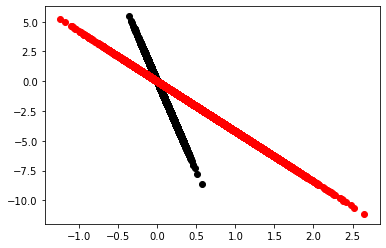

In [6]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2 
fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
data1    = inp_data1*fun_A1
data2    = inp_data2*fun_A2
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

In [7]:
## Hyperparameters
epochs     = 500
batch_size = 128
lr         = 1e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
## Creating synthetic dataloader

train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [9]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)

latent_dim1 = 1
latent_dim2 = 1
        
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler()  
        self.kl_div                  = kl_divergence_calculator.kl_divergence()
        ## Encoder set1
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim1)
        self.set1_enc2 = nn.Linear(in_features = 2*latent_dim1,out_features = 2*latent_dim1)
        ## Encoder set2
        self.set2_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim2)
        self.set2_enc2 = nn.Linear(in_features = 2*latent_dim2,out_features = 2*latent_dim2)
        ## Decoder set1
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = dim_exp,bias=False)
        ## Decoder set2
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = dim_exp,bias=False)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim1)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)

    def forward(self,x1,x2):
        data1    = x1
        data2    = x2
        ## encoding
# Modality 1
#         x1= x1.type(torch.cuda.FloatTensor)
#         x2= x2.type(torch.cuda.FloatTensor)
        x1       = self.set1_enc1(x1)
        x1       = self.set1_enc2(x1)
        mu1      = x1[:,0]
        mu1      = mu1.unsqueeze(0)
        mu1      = torch.transpose(mu1,0,1)    
        log_var1 = x1[:,1]
        log_var1 = log_var1.unsqueeze(0)
        log_var1 = torch.transpose(log_var1,0,1)    
        var1     = -torch.exp(log_var1)         # lambda_2<0
# Modality 2        
        x2       = self.set2_enc1(x2)
        x2       = self.set2_enc2(x2)        
        mu2      = x2[:,0]
        mu2      = mu2.unsqueeze(0)
        mu2      = torch.transpose(mu2,0,1)    
        log_var2 = x2[:,1]
        log_var2 = log_var2.unsqueeze(0)
        log_var2 = torch.transpose(log_var2,0,1) 
        var2     = -torch.exp(log_var2)           #lambdap_2<0
        g22      = -torch.exp(self.g22)     
        g11_copy = self.g11.detach()
        g22_copy = g22.detach()
        mu1_copy = mu1.detach()
        mu2_copy = mu2.detach()
        var1_copy=var1.detach()
        var2_copy=var2.detach()      
        if self.flag_initialize==1:
            z1_prior,z2_prior = self.gibbs.initialize_prior_sample(g11_copy,g22_copy)
            self.flag_initialize=0
            z1_posterior,z2_posterior = self.gibbs.initialize_posterior_sample(g11_copy,g22_copy,mu1_copy,var1_copy,mu2_copy,var2_copy)
            self.z1_prior =z1_prior
            self.z2_prior =z2_prior
            self.z1_posterior=z1_posterior
            self.z2_posterior=z2_posterior
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.prior_sample(z1_prior,z2_prior,self.g11,g22)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.posterior_sample(z1_posterior,z2_posterior,self.g11,g22,mu1,var1,mu2,var2)
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
         ## decoding

        reconstruction1=self.set1_dec1(self.z1_gibbs_posterior)
        reconstruction2=self.set2_dec1(self.z2_gibbs_posterior)
        ## loss
        mse_loss = nn.MSELoss(reduction='sum')
        MSE1     = mse_loss(reconstruction1, data1)
        MSE2     = mse_loss(reconstruction2, data2)
        KLD      = part_fun0+part_fun1+part_fun2
        loss     = MSE1+MSE2+KLD
        if self.flag_initialize==0:
#             make_dot(part_fun0,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun0", format="png")
#             make_dot(part_fun1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun1", format="png")
#             make_dot(part_fun2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun2", format="png")
#             make_dot(MSE1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE1", format="png")
#             make_dot(MSE2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE2", format="png")
#             make_dot(self.z1_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_prior", format="png")
#             make_dot(self.z2_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_prior", format="png")
#             make_dot(self.z1_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_posterior", format="png")
#             make_dot(self.z2_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_posterior", format="png")
            
            self.flag_initialize=5
        return reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss

In [10]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set1_dec1.weight
set2_dec1.weight


In [11]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(device)
        data2                        = data2.to(device)        
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss       = model(data1,data2)     
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
#         for p in model.parameters():
#             print(p.grad.norm())
    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    data1_val  = [] 
    data2_val  = [] 
    reconstruction1_pred=[]
    reconstruction2_pred=[]
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(device)
            data2                        = data2.to(device)      
            optimizer.zero_grad()
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss = model(data1,data2)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(var1)]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(var2)]
            reconstruction1_pred.append(reconstruction1)
            reconstruction2_pred.append(reconstruction2)
            data1_val.append(data1)
            data2_val.append(data2)

    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    reconstruction1_pred = torch.vstack(reconstruction1_pred)
    reconstruction2_pred = torch.vstack(reconstruction2_pred)
    data1_val   = torch.vstack(data1_val)
    data2_val   = torch.vstack(data2_val)

    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [12]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set2)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    
#     for name, para in model.named_parameters():
#         print(para)
    print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

Epoch 1 of 500
Train Loss    : 8.0706
Epoch 2 of 500
Train Loss    : 8.0438
Epoch 3 of 500
Train Loss    : 8.0323
Epoch 4 of 500
Train Loss    : 7.9858
Epoch 5 of 500
Train Loss    : 7.9655
Epoch 6 of 500
Train Loss    : 7.8990
Epoch 7 of 500
Train Loss    : 7.8805
Epoch 8 of 500
Train Loss    : 7.8457
Epoch 9 of 500
Train Loss    : 7.8191
Epoch 10 of 500
Train Loss    : 7.7496
Epoch 11 of 500
Train Loss    : 7.7201
Epoch 12 of 500
Train Loss    : 7.6781
Epoch 13 of 500
Train Loss    : 7.6303
Epoch 14 of 500
Train Loss    : 7.6140
Epoch 15 of 500
Train Loss    : 7.5240
Epoch 16 of 500
Train Loss    : 7.4817
Epoch 17 of 500
Train Loss    : 7.4398
Epoch 18 of 500
Train Loss    : 7.3647
Epoch 19 of 500
Train Loss    : 7.3544
Epoch 20 of 500
Train Loss    : 7.2560
Epoch 21 of 500
Train Loss    : 7.2035
Epoch 22 of 500
Train Loss    : 7.1493
Epoch 23 of 500
Train Loss    : 7.0682
Epoch 24 of 500
Train Loss    : 7.0213
Epoch 25 of 500
Train Loss    : 6.9947
Epoch 26 of 500
Train Loss    : 6.

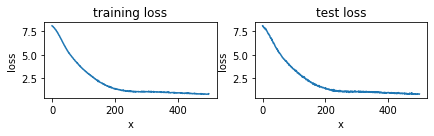

In [13]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

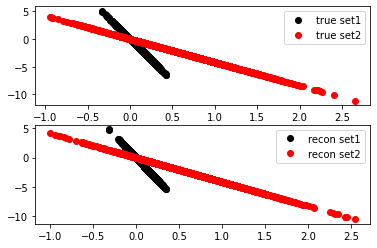

In [14]:
reconstruction1_x_cord = reconstruction1_pred[:,0].cpu().detach().numpy()
reconstruction1_y_cord = reconstruction1_pred[:,1].cpu().detach().numpy()
reconstruction2_x_cord = reconstruction2_pred[:,0].cpu().detach().numpy()
reconstruction2_y_cord = reconstruction2_pred[:,1].cpu().detach().numpy()
data1_x_cord = data1_val[:,0].cpu().detach().numpy()
data1_y_cord = data1_val[:,1].cpu().detach().numpy()
data2_x_cord = data2_val[:,0].cpu().detach().numpy()
data2_y_cord = data2_val[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
ax[0].plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='black',label='recon set1')
ax[1].plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='red',label='recon set2')
ax[1].legend()
plt.show()

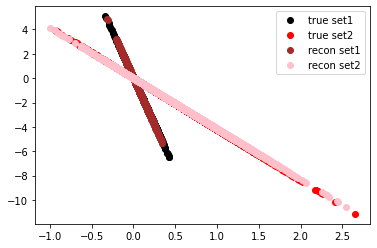

In [15]:
plt.plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
plt.plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
plt.plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='brown',label='recon set1')
plt.plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='pink',label='recon set2')
plt.legend()
plt.show()